# Style Transfer with Deep Neural Networks


In this notebook, I’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers.

### Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

In this notebook, I'll use a pre-trained VGG19 Net to extract content or style features from an image.

In [1]:
# import resources
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from os import path
import pickle
#from google.colab import drive

import cv2
import torch
from torchvision import models

from helper import *
from transfer import *

%matplotlib inline

In [ ]:
#drive.mount('/content/drive', force_remount=True)

In [2]:
from ipywidgets import IntProgress

# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since I'm only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'===== Using {device} =====')

vgg.to(device);

print(torch.cuda.get_device_name(0))

===== Using cuda =====
GeForce GTX 960M


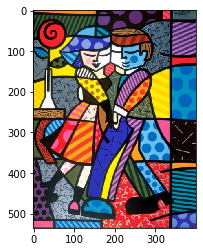

In [4]:
# Style to be applied
style = load_image('romero_02.jpg').to(device)
plt.imshow(im_convert(style))
plt.show()

### Only run the following cell if you don't have the video frames

In [5]:
img_array = []
 
# Opens the Video file
cap = cv2.VideoCapture('foreman.mp4')

# https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html
# https://stackoverflow.com/questions/39953263/get-video-dimension-in-python-opencv/39953739
width = int(cap.get(3))
height = int(cap.get(4))
fps = round(cap.get(5))
total_frames = int(cap.get(7))

# Saving info to file
with open('properties.pkl', 'wb') as f:
    pickle.dump([width, height, fps, total_frames], f)

current_frame_number = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    img_array.append(frame)
    
    file_name = 'frames/input frames/input_frame_{:08d}.jpg'.format(current_frame_number)
    matplotlib.image.imsave(file_name, img_array[-1])
    current_frame_number += 1

cap.release()
cv2.destroyAllWindows()
img_array.clear()

### Reading frames saved to disk from the input video.

This allows me to run this notebook in parts.

In [6]:
# Loading frames from files
with open('properties.pkl', 'rb') as f:
    width, height, fps, total_frames = pickle.load(f)

input_frames = []

current_frame_number = 0
#file_name = '/content/drive/My Drive/Colab Notebooks/frames/input frames/input_frame_{:08d}.jpg'.format(current_frame_number)
file_name = 'frames/input frames/input_frame_{:08d}.jpg'.format(current_frame_number)

while path.exists(file_name):
    input_frames.append(load_image(file_name).to(device))
    current_frame_number += 1
    #file_name = '/content/drive/My Drive/Colab Notebooks/frames/input frames/input_frame_{:08d}.jpg'.format(current_frame_number)
    file_name = 'frames/input frames/input_frame_{:08d}.jpg'.format(current_frame_number)

### If you already have the stylized frames, skip the next cell

In [ ]:
# Transfering style and saving to file
for idx, image in enumerate(input_frames):
    print(f'Currently evaluating frame {idx + 1} of {total_frames}')
    #content = prepare_image(image).to(device)
    frame = transfer_to_frame(image, style, vgg, device)
    
    #file_name = '/content/drive/My Drive/Colab Notebooks/frames/style frames/stylized_frame_{:08d}.jpg'.format(idx)
    file_name = 'frames/style frames/stylized_frame_{:08d}.jpg'.format(idx)
    current = frame.to('cpu').detach()
    matplotlib.image.imsave(file_name, im_convert(current))

In [7]:
stylized_frames = []

# Load stylized frames from file
current_frame_number = 0
#file_name = '/content/drive/My Drive/Colab Notebooks/frames/style frames/stylized_frame_{:08d}.jpg'.format(current_frame_number)
file_name = 'frames/style frames/stylized_frame_{:08d}.jpg'.format(current_frame_number)

while path.exists(file_name):
    stylized_frames.append(load_image(file_name).to(device))
    current_frame_number += 1
    #file_name = '/content/drive/My Drive/Colab Notebooks/frames/style frames/stylized_frame_{:08d}.jpg'.format(current_frame_number)
    file_name = 'frames/style frames/stylized_frame_{:08d}.jpg'.format(current_frame_number)


In [8]:
final_frames = []

# Convert tensors back to numpy arrays
for tensor_frame in stylized_frames:
    temp_frame = (im_convert(tensor_frame)*255).astype(np.uint8)
    final_frames.append(cv2.resize(temp_frame, dsize=(width, height), interpolation=cv2.INTER_CUBIC))

In [9]:
out = cv2.VideoWriter('stylized_video.mp4', cv2.VideoWriter_fourcc(*'X264'), fps, (width, height))
 
for i in range(len(final_frames)):
    out.write(final_frames[i])
out.release()